## Paquetes que son necesarios

In [10]:
import os
import numpy as np
from matplotlib import pyplot as plt
import sys
import pandas as pd
import csv
import math
%matplotlib inline

# Estructura de datos de los archivos de Tracking Tools

Frame: Details frame of exported data in the following format:

1. Frame Index (integer) 
2. Time Stamp (double) in seconds
3. Trackable Count (integer) number of trackables tracked in current frame
4. ID
5. x
6. y
7. z
8. qx
9. qy
10. qz
11. qw
12. yaw
13. pitch
14. roll
15. Marker Count (integer) Count of all visibile markers in frame"
16. Marker Detail >for each reconstructed 3d marker< (x,y,z,id)

# Funciones 

In [11]:
def getMatrixOptitrack(x, y, z, qx, qy, qz, qw):
    """Return  the matrix from quaternion and traslation from Optitrack
    """
    R = np.eye(4)
    R[0, 0] = -2 * qy*qy - 2 * qz*qz + 1
    R[0, 1] = 2 * qw*qz + 2 * qx*qy
    R[0, 2] = 2 * qw*qy - 2 * qx*qz
    R[0, 3] = x

    R[1, 0] = 2 * qx*qy - 2 * qw*qz
    R[1, 1] = -2 * qx*qx - 2 * qz*qz + 1
    R[1, 2] = -2 * qw*qx - 2 * qy*qz
    R[1, 3] = y

    R[2, 0] = -2 * qw*qy - 2 * qx*qz
    R[2, 1] = 2 * qw*qx - 2 * qy*qz
    R[2, 2] = -2 * qx*qx - 2 * qy*qy + 1
    R[2, 3] = z

    R[3, 0] = 0.0
    R[3, 1] = 0.0
    R[3, 2] = 0.0
    R[3, 3] = 1.0
    return R

In [6]:
def getDataFromCSVTrackingTools(myfilename):
    """Read an Optitrack data file and extract the movement from the file. 
        Return a pandas dataframe (can be read using csv package too)
    """
    data = []
    with open(myfilename, 'rb') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',')
        for row in spamreader:
            if row[0] == 'frame':
                data.append({
                            'time':float(row[2]),\
                            'id':float(row[4]),\
                            'x':float(row[5])*1000,\
                            'y':float(row[6])*1000,\
                            'z':float(row[7])*1000,\
                            'qx':float(row[8]),\
                            'qy':float(row[9]),\
                            'qz':float(row[10]),\
                            'qw':float(row[11])\
                    })

    df = pd.DataFrame(data)
    return df

In [9]:
def getMatrixOptitrackFromDF(df,i):
    """Get the transformation matrix from the data frame in row i
    """
    return getMatrixOptitrack(df['x'].loc[i],\
                              df['y'].loc[i],\
                              df['z'].loc[i],\
                              df['qx'].loc[i],\
                              df['qy'].loc[i],\
                              df['qz'].loc[i],\
                              df['qw'].loc[i])

In [30]:
def decompose_matrix(matrix):
    """Return sequence of transformations from transformation matrix.

    matrix : array_like
        Non-degenerative homogeneous transformation matrix

    Return tuple of:
        scale : vector of 3 scaling factors
        shear : list of shear factors for x-y, x-z, y-z axes
        angles : list of Euler angles about static x, y, z axes
        translate : translation vector along x, y, z axes
        perspective : perspective partition of matrix

    Raise ValueError if matrix is of wrong type or degenerative.

    """
    M = np.array(matrix, dtype=np.float64, copy=True).T
    if abs(M[3, 3]) < np.finfo(float).eps:
        raise ValueError("M[3, 3] is zero")
    M /= M[3, 3]
    P = M.copy()
    P[:, 3] = 0.0, 0.0, 0.0, 1.0
    if not np.linalg.det(P):
        raise ValueError("matrix is singular")

    scale = np.zeros((3, ))
    shear = [0.0, 0.0, 0.0]
    angles = [0.0, 0.0, 0.0]

    if any(abs(M[:3, 3]) > np.finfo(float).eps):
        perspective = np.dot(M[:, 3], np.linalg.inv(P.T))
        M[:, 3] = 0.0, 0.0, 0.0, 1.0
    else:
        perspective = np.array([0.0, 0.0, 0.0, 1.0])

    translate = M[3, :3].copy()
    M[3, :3] = 0.0

    row = M[:3, :3].copy()
    scale[0] = vector_norm(row[0])
    row[0] /= scale[0]
    shear[0] = np.dot(row[0], row[1])
    row[1] -= row[0] * shear[0]
    scale[1] = vector_norm(row[1])
    row[1] /= scale[1]
    shear[0] /= scale[1]
    shear[1] = np.dot(row[0], row[2])
    row[2] -= row[0] * shear[1]
    shear[2] = np.dot(row[1], row[2])
    row[2] -= row[1] * shear[2]
    scale[2] = vector_norm(row[2])
    row[2] /= scale[2]
    shear[1:] /= scale[2]

    if np.dot(row[0], np.cross(row[1], row[2])) < 0:
        np.negative(scale, scale)
        np.negative(row, row)

    angles[1] = math.asin(-row[0, 2])
    if math.cos(angles[1]):
        angles[0] = math.atan2(row[1, 2], row[2, 2])
        angles[2] = math.atan2(row[0, 1], row[0, 0])
    else:
        #angles[0] = math.atan2(row[1, 0], row[1, 1])
        angles[0] = math.atan2(-row[2, 1], row[1, 1])
        angles[2] = 0.0

    return scale, shear, angles, translate, perspective

def vector_norm(data, axis=None, out=None):
    """Return length, i.e. Euclidean norm, of ndarray along axis.
    """
    data = np.array(data, dtype=np.float64, copy=True)
    if out is None:
        if data.ndim == 1:
            return math.sqrt(np.dot(data, data))
        data *= data
        out = numpy.atleast_1d(np.sum(data, axis=axis))
        np.sqrt(out, out)
        return out
    else:
        data *= data
        np.sum(data, axis=axis, out=out)
        np.sqrt(out, out)
        
def correctAngle(data):
    """Correct the jumps in angles
    """
    
    prev = data[0]
    thr = np.mean(np.diff(data)) + 5*np.std(np.diff(data))
    
    sign = 1
    for i in np.arange(1,len(data),1):

        dif_it = np.abs(data[i] - prev)
        
        prev = data[i]

        if(dif_it > thr):
            sign = sign * (-1)
            
        if sign < 0:
            data[i] = data[i] + 2*180

    return data

In [31]:
def PCA(A):
    """ performs principal components analysis 
     (PCA) on the n-by-p data matrix A
     Rows of A correspond to observations, columns to variables. 

    Returns :  
    coeff :
    is a p-by-p matrix, each column containing coefficients 
    for one principal component.
    score : 
    the principal component scores; that is, the representation 
    of A in the principal component space. Rows of SCORE 
    correspond to observations, columns to components.
    latent : 
    a vector containing the eigenvalues 
    of the covariance matrix of A.
    """
    # computing eigenvalues and eigenvectors of covariance matrix
    M = (A-np.mean(A.T,axis=1)).T # subtract the mean (along columns)
    [latent,coeff] = np.linalg.eig(np.cov(M)) # attention:not always sorted
    score = np.dot(coeff.T,M).T # projection of the data in the new space
    return coeff,score,latent

# Solución mediante PCA

## Teoría

El ángulo se extrae mediante un análisis de PCA que determina la dirección de máxima variación. Si se conoce el eje de giro (rotación, flexión lateral, flexión de extensión) se pueden analizar las rotaciones obtenidas mediante el sistema de tracking y analizar la dirección de máxima variación.

Los pasos a seguir para la realización de las medidas con un paciente son:
1. Pedir que mueva la cabeza de derecha a izquierda en rotación.
2. Pedir que mueva la cabeza en flexión lateral de derecha a izquierda
3. Pedir que mueva la cabeza en flexión de extensión de arriba a abajo.
4. Con los datos recogidos en cada caso se extraen los ángulos de Euler y se realiza un PCA de las componentes.
5. La componente con mayor autovalor de la matriz de covarianza será la que se emplee como medición del ángulo.
6. Como el paciente comienza en posición natural, se tomará dicha posición como ángulo cero y se medirán positivos (derecha, arriba) y ángulos negativos (izquierda, abajo) según angulación.

In [32]:
def GetAngles(rotation_file, flex_lat_file, flex_ext_file):
    
    # Read data from files (This can be done by reading data directly from Optitrack Tracking)
    df_rotation = getDataFromCSVTrackingTools(rotation_file)
    df_flex_lat = getDataFromCSVTrackingTools(flex_lat_file)
    df_flex_ext = getDataFromCSVTrackingTools(flex_ext_file)
    
    
    # Extract Euler Angles for each case
    
    # Rotation
    N = len(df_rotation.index)
    eulerAng_rotation = np.zeros((N,3))
    for i in np.arange(0,N,1):
        Ti = getMatrixOptitrackFromDF(df_rotation,i)
        scale, shear, angles, translate, perspective = decompose_matrix(Ti)
        eulerAng_rotation[i,0] = np.degrees(angles[0])
        eulerAng_rotation[i,1] = np.degrees(angles[1])
        eulerAng_rotation[i,2] = np.degrees(angles[2])
        
    # Flex Lateral
    N = len(df_flex_lat.index)
    eulerAng_flex_lat = np.zeros((N,3))
    for i in np.arange(0,N,1):
        Ti = getMatrixOptitrackFromDF(df_flex_lat,i)
        scale, shear, angles, translate, perspective = decompose_matrix(Ti)
        eulerAng_flex_lat[i,0] = np.degrees(angles[0])
        eulerAng_flex_lat[i,1] = np.degrees(angles[1])
        eulerAng_flex_lat[i,2] = np.degrees(angles[2])
        
    # Flex Extensión
    N = len(df_flex_ext.index)
    eulerAng_flex_ext = np.zeros((N,3))
    for i in np.arange(0,N,1):
        Ti = getMatrixOptitrackFromDF(df_flex_ext,i)
        scale, shear, angles, translate, perspective = decompose_matrix(Ti)
        eulerAng_flex_ext[i,0] = np.degrees(angles[0])
        eulerAng_flex_ext[i,1] = np.degrees(angles[1])
        eulerAng_flex_ext[i,2] = np.degrees(angles[2])
        
    # Angles correction
    
    eulerAng_rotation[:,0] = correctAngle(eulerAng_rotation[:,0])
    eulerAng_rotation[:,1] = correctAngle(eulerAng_rotation[:,1])
    eulerAng_rotation[:,2] = correctAngle(eulerAng_rotation[:,2])
    
    eulerAng_flex_lat[:,0] = correctAngle(eulerAng_flex_lat[:,0])
    eulerAng_flex_lat[:,1] = correctAngle(eulerAng_flex_lat[:,1])
    eulerAng_flex_lat[:,2] = correctAngle(eulerAng_flex_lat[:,2])
    
    eulerAng_flex_ext[:,0] = correctAngle(eulerAng_flex_ext[:,0])
    eulerAng_flex_ext[:,1] = correctAngle(eulerAng_flex_ext[:,1])
    eulerAng_flex_ext[:,2] = correctAngle(eulerAng_flex_ext[:,2])
    
    
        
    
    # PCA and zero setting of the data
    coeff_rotation,score_rotation,latent_rotation = PCA(eulerAng_rotation)
    coeff_flex_lat,score_flex_lat,latent_flex_lat = PCA(eulerAng_flex_lat)
    coeff_flex_ext,score_flex_ext,latent_flex_ext = PCA(eulerAng_flex_ext)
    
    angleData_rotation = score_rotation[:,0] - score_rotation[0,0]
    angleData_flex_lat = score_flex_lat[:,0] - score_flex_lat[0,0]
    angleData_flex_ext = score_flex_ext[:,0] - score_flex_ext[0,0]
    
    time_rotation = df_rotation.time.values
    time_flex_lat = df_flex_lat.time.values
    time_flex_ext = df_flex_ext.time.values
    
    
    # Printing results
    
    percentage_rotation = 100*latent_rotation/np.sum(latent_rotation)
    percentage_flex_lat = 100*latent_flex_lat/np.sum(latent_flex_lat)
    percentage_flex_ext = 100*latent_rotation/np.sum(latent_rotation)
    
    print "Percentage of explanation: [{0:.2f}, {1:.2f}, {2:.2f}]".format(percentage_rotation[0],\
                                                                          percentage_flex_lat[0],\
                                                                          percentage_flex_ext[0])
    
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(time_rotation, angleData_rotation,'r', label="Rotation", linestyle='-', lw = 2)
    ax.plot(time_flex_lat, angleData_flex_lat,'g', label="Flex Lat", linestyle='-.', lw = 2)
    ax.plot(time_flex_ext, angleData_flex_ext,'b', label="Flex Ext", linestyle=':', lw = 2)
    ax.legend(loc='best')
    ax.set_xlabel('Time (sec)')
    ax.set_ylabel('Angles (degrees)')
    ax.set_title('Angles from test\n')
    plt.show() 
    
    
    

## Example of use

Percentage of explanation: [98.43, 90.88, 98.43]


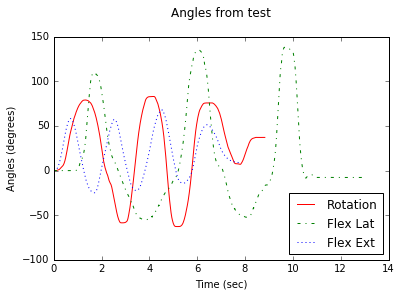

In [33]:
rotation_file = 'J:/Dev/AlgiaCervical/DataTest/rotacion.csv'
flex_lat_file = 'J:/Dev/AlgiaCervical/DataTest/flexion-lateral.csv'
flex_ext_file = 'J:/Dev/AlgiaCervical/DataTest/flexo-extension.csv'

GetAngles(rotation_file, flex_lat_file, flex_ext_file)
